In [219]:
# Pure solution dataset: 
# https://figshare.com/articles/dataset/Pure_solution_dataset/20399181?file=36468375

# Based on "Integrated biosensor platform based on graphene transistor arrays for real-time high-accuracy ion sensing"
# Link: https://www.nature.com/articles/s41467-022-32749-4

In [332]:
import numpy as np
import math
import random

import matplotlib.pyplot as plt
from matplotlib.ticker import ScalarFormatter, FuncFormatter
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score

from scipy.ndimage import uniform_filter1d
import warnings
from scipy.optimize import OptimizeWarning
warnings.simplefilter("error", OptimizeWarning)

class Dataset():
    def __init__(self, filenames, apt_filename):
        '''
        This Dataset class serves to process data for GFET data, for a single data well, including
        multiple devices per well, over the gate voltage sweeps for multiple concentrations.
        
        Parameters:
            filenames: list of filenames that contains gate voltage sweeps, each for a single concentration
            apt_filename: the filename of the voltage sweep for the devices with only the aptamer
        Returns:
            None

        Format of each file:
            First column: gate voltage
            All other columns: Drain-Source current for a single device. Each row shows the current
            experienced by each device for the gate voltage of the 1st column.

        This assumes that all of the aptamer and linker data along with ALL concentrations share the same gate voltage steps.
        The initial dirac voltage does not have to have the same gate voltage steps.
        '''
        # initialize raw data and the data's basic features
        self.num_concs = len(filenames) # number of concentrations tested
        self.num_devices = 0 # number of devices in the well at hand, set super high to start it will get smaller later
        self.voltages = [] # list of the voltages we sweep over
        for conc in range(self.num_concs): # calcluate the voltages list, number of voltages, and number of devices
            raw_data = np.loadtxt('data/'+filenames[conc]).T
            if len(raw_data[0,:]) > len(self.voltages): 
                self.voltages = raw_data[0,:] # gets the biggest list of voltages to sweep over (some stop at 1.5V and others at 1.4V, we want 1.5)

        self.index_to_device_index = np.loadtxt('data/Xue_data_NA/Xue_data_Na_indices.txt', dtype=int).T
        self.bad_indices = {1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,21,22,23,25,27,29,30,34,43,47,81,82,83,84,85,86,88,89,91,92,98,101,123,130,132,133,134,142,143,145,146,147,148,149,151,152,153,155,158,159,161,162,163,164,165,166,167,168,169,170,172,173,174,175,176,178,183,186,187,188,191,200,203,213,219,237,238,250,252,256}
        self.apt_currents_array = np.loadtxt('data/'+apt_filename)[:, 1:].T # (device_index, voltage_reading)

        self.num_devices = len(self.index_to_device_index)

        self.currents = {}  # dictionary of dictionary of currents list. {concentration_num: {device_number: list_of_currents}}
        for conc in range(self.num_concs):
            conc_data_dic = {}
            for dev_num in range(self.num_devices):
                raw_data = np.loadtxt('data/'+filenames[conc]).T
                conc_data_dic[dev_num] = raw_data[dev_num+1]
            self.currents[conc] = conc_data_dic

        # # window mena-filtering data
        # for dev in range(self.num_devices):
        #     for conc in range(self.num_concs):
        #         window_size = 7
        #         mean_filtered_data = uniform_filter1d(self.currents[conc][dev], size=window_size, mode='reflect')
        #         plt.plot(self.currents[conc][dev])
        #         plt.plot(mean_filtered_data)
        #     plt.show()
        #     plt.close()

        self.apt_currents = {}
        dev_count = 0
        for idx in range(len(self.index_to_device_index)):
            dev_idx = self.index_to_device_index[idx]
            self.apt_currents[dev_count] = self.apt_currents_array[dev_idx]
            dev_count += 1

        # builds current derivative info
        self.current_derivatives = {} # dictionary of dictionary of delta current list. {concentration_num: {device_number: list_of_current_changes}}
        for conc in range(self.num_concs):
            conc_current_derivative = {}
            for dev_num in range(self.num_devices): 
                conc_current_derivative[dev_num] = [self.currents[conc][dev_num][i] - self.currents[conc][dev_num][i+1] for i in range(len(self.currents[conc][dev_num])-1)]
            self.current_derivatives[conc] = conc_current_derivative
        self.apt_current_derivatives = {} # dictionary of lists of aptemer delta current. {device_number: list_of_current_changes}
        for dev_num in range(self.num_devices): 
            self.apt_current_derivatives[dev_num] = [self.apt_currents[dev_num][i] - self.apt_currents[dev_num][i+1] for i in range(len(self.apt_currents[dev_num])-1)]

        range_min_idx = 50
        range_max_idx = 100
        
        # builds dirac voltage info
        self.apt_dirac_voltages = {} # dictionary of lists for dirac voltages for the aptemer. The list enumerates the concentrations. {device_number: dirac_voltage_list}
        for dev_num in range(self.num_devices):
            self.apt_dirac_voltages[dev_num] = self.voltages[np.argmin(self.apt_currents[dev_num])]
        self.dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltages. x:concentration, y: device_number
        self.adj_dirac_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of dirac voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.dirac_voltages[conc,dev_num] = self.voltages[range_min_idx+np.argmin(self.currents[conc][dev_num][range_min_idx:range_max_idx])]
                self.adj_dirac_voltages[conc,dev_num] = self.voltages[range_min_idx+np.argmin(self.currents[conc][dev_num][range_min_idx:range_max_idx])] - self.apt_dirac_voltages[dev_num]

        # builds info about transconductance voltages, both pos and neg
        self.apt_pos_transc_voltages = {} # dictionary of lists for positive transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: pos_transc_v_list}
        self.apt_neg_transc_voltages = {}# dictionary of lists for negative transconductance voltages for the aptemer. The list enumerates the concentrations. {device_number: neg_transc_v_list}
        for dev_num in range(self.num_devices):
                self.apt_pos_transc_voltages[dev_num] = self.voltages[np.argmax(self.apt_current_derivatives[dev_num])]
                self.apt_neg_transc_voltages[dev_num] = self.voltages[np.argmin(self.apt_current_derivatives[dev_num])]
        self.pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltages. x:concentration, y: device_number
        self.neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltages. x:concentration, y: device_number
        self.adj_pos_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of positive transconductance voltage shifts (adjusted). x:concentration, y: device_number
        self.adj_neg_transc_voltages = np.zeros((self.num_concs, self.num_devices)) # 2D array of negative transconductance voltage shifts (adjusted). x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                self.pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.current_derivatives[conc][dev_num])]
                self.neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.current_derivatives[conc][dev_num])]
                self.adj_pos_transc_voltages[conc, dev_num] = self.voltages[np.argmax(self.current_derivatives[conc][dev_num])] - self.apt_pos_transc_voltages[dev_num]
                self.adj_neg_transc_voltages[conc, dev_num] = self.voltages[np.argmin(self.current_derivatives[conc][dev_num])] - self.apt_neg_transc_voltages[dev_num]

        
#         # # # builds info about conductances
#         # # self.apt_conductances = {dev_num: 1/self.apt_currents[dev_num] for dev_num in range(self.num_devices)} # dictionary of lists of conductances for the aptamer readings. {device_number: conductance_list}
#         # self.conductances = {} # dictionary of dictionaries of lists for conductance readings. {concentration: {device_number: conductance_list}}
#         # for conc in range(self.num_concs):
#         #     self.conductances[conc] = [1 / self.currents[conc][dev_num] for dev_num in range(self.num_devices)]

#         # # builds info about conductance derivatives
#         # self.conductance_derivatives = {} # dictionary of dictionary of delta conductance list. {concentration_num: {device_number: list_of_conductance_changes}}
#         # for conc in range(self.num_concs):
#         #     conc_conductance_derivative = {}
#         #     for dev_num in range(self.num_devices): 
#         #         conc_conductance_derivative[dev_num] = [self.conductances[conc][dev_num][i] - self.conductances[conc][dev_num][i+1] for i in range(len(self.conductances[conc][dev_num])-1)]
#         #     self.conductance_derivatives[conc] = conc_conductance_derivative
#         # # self.apt_conductance_derivatives = {} # dictionary of lists of aptemer delta conductance. {device_number: list_of_conductance_changes}
#         # # self.id_conductance_derivatives = {} # dictionary that has the same structure as apt_conductance_derivatives, but for initial dirac sweep
#         # # self.linker_conductance_derivatives = {}
#         # # for dev_num in range(self.num_devices): 
#         # #     self.apt_conductance_derivatives[dev_num] = [self.apt_conductances[dev_num][i] - self.apt_conductances[dev_num][i+1] for i in range(len(self.apt_conductances[dev_num])-1)]
#         # #     self.id_conductance_derivatives[dev_num] = [self.id_conductances[dev_num][i] - self.id_conductances[dev_num][i+1] for i in range(len(self.id_conductances[dev_num])-1)]
#         # #     self.linker_conductance_derivatives[dev_num] = [self.linker_conductances[dev_num][i] - self.linker_conductances[dev_num][i+1] for i in range(len(self.linker_conductances[dev_num])-1)]


    def conductance_shifts(self, voltage_to_track):
        '''
        Calculates the conductance shift over different concentrations, for a static gate voltage.

        Returns:
            2D array of conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        '''
        voltage_idx = np.abs(self.voltages - voltage_to_track).argmin() # index of voltage we want to track in self.voltages. The voltage can be an average of others so it may not be on the list

        # builds the 2D array of conductances at a voltage
        conductance_at_voltage = np.zeros((self.num_concs, self.num_devices)) # 2D array of conductances. x:concentration, y: device_number
        for conc in range(self.num_concs):
            for dev_num in range(self.num_devices):
                conductance_at_voltage[conc, dev_num] = self.conductances[conc][dev_num][voltage_idx]

        # builds the 2D array of the change in conductances at a voltage. This change is with respect to the aptamer conductance
        delta_conductance = np.zeros((self.num_concs, self.num_devices)) # 2D list tracking the change in conductances. x:concentration, y: device_number
        for dev_num in range(self.num_devices):
            delta_conductance[:,dev_num] = conductance_at_voltage[:,dev_num] # - self.apt_conductances[dev_num][voltage_idx]

        return delta_conductance

    
    def normalize_2D_array(self, delta_Y, Y_0):
        Y_norm = np.zeros((self.num_concs, self.num_devices))
        for dev_num in range(self.num_devices):
            Y_norm[:,dev_num] = ((-delta_Y[:,dev_num] + Y_0[dev_num]) / Y_0[dev_num]) #  * 100
        return Y_norm

    
    def normalized_conductance_shifts(self, voltage_to_track):
        '''
        Calculates the normalized conductance shift over different concentrations, for a specific gate voltage.
        Normalization strategy is
                (I_0-I) / I_0 , 
        where I_0 is the aptamer coductance

        Returns:
            2D array of normalized conductance shifts, x: concentration, y: device_number
        Paramerers:
            voltage_to_track: gate voltage to fix, must be in the list self.voltages
        
        '''
        delta_G = self.conductance_shifts(voltage_to_track) # un-normalized conductance shift

        return delta_G
        
        # voltage_idx = np.abs(self.voltages - voltage_to_track).argmin() # index of voltage we want to track in self.voltages

        # # builds G_0 list
        # G_0 = {} # aptamer conductance, 
        # for dev_num in range(self.num_devices):
        #     G_0[dev_num] = self.apt_conductances[dev_num][voltage_idx]

        # # # builds G_norm array
        # # G_norm = np.zeros((self.num_concs, self.num_devices))
        # # for dev_num in range(self.num_devices):
        # #     # G_norm[:,dev_num] = (G_0[dev_num] - delta_G[:,dev_num]) / G_0[dev_num]
        # #     G_norm[:,dev_num] = (delta_G[:,dev_num] - G_0[dev_num]) / G_0[dev_num]

        # # return G_norm
        # return self.normalize_2D_array(delta_G, G_0)


    def analysis(self, data_array_2D):
        '''
        Performs curve fitting of a data array vs concentration. For example, Dirac Voltage vs concentration, or conductance vs concentration.

        # Returns:
        #     concentrations_list: The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D was flattened
        #     data_array_flattened: The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
        #     hill_coeffs = (A, K, n, b): Coefficients for hill curve fitted to distribution
        #     std_devs: The list, as long as the number of concentrations, for the standard deviations at each concentration
        #     S: sensitivity
        #     LOD: Limit of detection
        #     r2: r^2 value on how the hill curve fits the points
        Parameters:
            data_array_2D: 2D array of data we want to use. Must have x: concentration, y: device_number
        '''
        mean_array = np.mean(data_array_2D, axis=1)
        std_array = np.std(data_array_2D, axis=1)
        hill_coeffs_mean, c = curve_fit(hill_function, range(self.num_concs), mean_array, method='trf') # , method='trf') #, max_nfev=10000, xtol=1e-6, ftol=1e-6)
        
        inf_point_x = inflection_point_hill_function(*hill_coeffs_mean)
        S = derivative_hill_function(inf_point_x, *hill_coeffs_mean)
        LOD = 3.3 * std_array[0] / S
        LOQ = 10 * std_array[0] / S

        # claculating r^2
        concentrations_list = np.repeat(range(self.num_concs), self.num_devices) # The list of concentrations that corresponds to the data_array_flattened list. Neeed because the data_array_2D is flattened
        data_array_flattened = data_array_2D.flatten() # The flattened list from data_array_2D, needed because pyplot cannot plot 2D matrices.
        # hill_coeffs, c = curve_fit(hill_function, concentrations_list, data_array_flattened) # fits the datapoints to hill_function, the hill curve
        # # std_devs = [] # calculates the standard deviation for each concentration
        # # for i in range(self.num_concs):
        # #     mu = hill_function(i, *hill_coeffs)
        # #     val = np.sqrt(1/self.num_devices * sum([(mu - x_j)**2 for x_j in data_array_flattened[i*self.num_devices:i*(self.num_devices+1)]]))
        # #     std_devs.append(val)

        predicted_data = [hill_function(conc, *hill_coeffs_mean) for conc in concentrations_list]
        r2 = r2_score(data_array_flattened, predicted_data)

        print('Sensitivty', S)
        print(LOD)
        print('Calculated Limit of Detection', 10**(-6+LOD))
        print('r2', r2)

        plt.plot(mean_array)
        X_fit = np.linspace(0, self.num_concs-1, 50)
        Y_fit = hill_function(X_fit, *hill_coeffs_mean)
        for i in range(self.num_concs):
            for j in range(self.num_devices):
                plt.scatter(i, data_array_2D[i,j], color='blue')
        plt.plot(X_fit, Y_fit)
        plt.plot([0,self.num_concs-1], [0,0], color='magenta', linestyle='--', label='Antibody voltage')
        x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-6]
        plt.xticks(range(dataset.num_concs), x_labels)
        y_ticks = plt.yticks()[0]  # Get current y-tick locations
        plt.yticks(y_ticks, [f'{int(tick * 100)}' for tick in y_ticks])
        plt.title('Na+\nNormalized Peak Dirac Voltage Shift')
        plt.xlabel("Concentration (M)")
        # plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
        plt.legend()
        plt.show()
        plt.close()

        plt.plot(mean_array)
        X_fit = np.linspace(0, self.num_concs-1, 50)
        Y_fit = hill_function(X_fit, *hill_coeffs_mean)
        plt.plot(X_fit, Y_fit)
        plt.errorbar(concs, hill_function(concs, *hill_coeffs_mean), yerr=std_array, ecolor='black', fmt='None', capsize=5, alpha=0.7)
        plt.plot([0,self.num_concs-1], [0,0], color='magenta', linestyle='--', label='Antibody voltage')
        x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-6]
        plt.xticks(range(dataset.num_concs), x_labels)
        y_ticks = plt.yticks()[0]  # Get current y-tick locations
        plt.yticks(y_ticks, [f'{int(tick * 100)}' for tick in y_ticks])
        plt.title('Na+\nNormalized Peak Dirac Voltage Shift')
        plt.xlabel("Concentration (M)")
        plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
        plt.legend()
        plt.show()
        plt.close()
        

        



        
        # plot_arr = [np.mean(data_array_2D[i,:]) for i in range(self.num_concs)]
        # plt.plot(plot_arr)
        # plt.show()
        # plt.close()
        # print('----------------------')
        # for dev in range(self.num_devices):
        #     for conc in range(self.num_concs):
        #         plt.scatter(conc, data_array_2D[conc, dev])
        # plt.show()
        # plt.close()
        # hill_coeffs_array = np.zeros([self.num_devices, 4])
        counter = 0
        for dev_num in range(self.num_devices):
            try:
                # hill_coeffs, c = curve_fit(hill_function, range(self.num_concs), data_array_2D[:,dev_num].T, method='trf', max_nfev=10000, xtol=1e-5, ftol=1e-5)
                # hill_coeffs_array[dev_num,:] = hill_coeffs
                # plt.scatter(range(self.num_concs), data_array_2D[:,dev_num])
                # hill_coeffs = hill_coeffs_array[dev_num]
                # X_fit = np.linspace(0, self.num_concs-1, 50)
                # Y_fit = hill_function(X_fit, *hill_coeffs)
                # plt.plot(X_fit, Y_fit)
                plt.scatter(range(self.num_concs), data_array_2D[:, dev_num].T)
                plt.title('Na+, Device number '+str(dev_num))
                plt.xlabel('Concentration')
                y_ticks = plt.yticks()[0]  # Get current y-tick locations
                plt.yticks(y_ticks, [f'{int(tick * 100)}' for tick in y_ticks])
                plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
                plt.show()
                plt.close()
                counter += 1
            except Exception as e:
                print(e)
                print('could not predict device', dev_num)
                pass
        print(counter)
        plt.close()
        return

        # mean_array = [np.mean(data_array_2D[i,:]) for i in range(self.num_concs)]
        




        
        # predicted_data_array_2D = np.zeros([self.num_concs, self.num_devices])
        # for dev_num in range(self.num_devices):
        #     hill_coeffs = hill_coeffs_array[dev_num]
        #     predicted_data_array_2D[:, dev_num] = np.array([hill_function(conc, *hill_coeffs) for conc in range(self.num_concs)]).T

        # hill_coeffs_avg = np.mean(hill_coeffs_array, axis=0)
        # # avg_predictions = np.array([hill_function(conc, *hill_coeffs_avg) for conc in range(self.num_concs)])
        # avg_predictions = hill_function(range(self.num_concs), *hill_coeffs_avg)
        
        # prediction_std_devs = []
        # for conc in range(self.num_concs):
        #     mu = avg_predictions[conc]
        #     prediction_std_devs.append(math.sqrt(1/self.num_devices * sum([(data_array_2D[conc][dev_num] - mu)**2 for dev_num in range(self.num_devices)])))

        # prediction_std_devs = np.array(prediction_std_devs)


        
        # for dev_num in range(self.num_devices):
        #     plt.scatter(range(self.num_concs), data_array_2D[:,dev_num])
        #     hill_coeffs = hill_coeffs_array[dev_num]
        #     X_fit = np.linspace(0, self.num_concs-1, 50)
        #     Y_fit = hill_function(X_fit, *hill_coeffs)
        #     plt.plot(X_fit, Y_fit)
        # X_fit = np.linspace(0, self.num_concs-1, 50)
        # avg_hill_coeffs = np.mean(hill_coeffs_array, axis=0)
        # print(avg_hill_coeffs.shape)
        # Y_fit = hill_function(X_fit, *avg_hill_coeffs)
        # plt.plot(X_fit, Y_fit, color='black')
        # plt.show()
        # plt.close()
    

        # # calculates experimental range
        # exp_range = []
        # for dev_num in range(self.num_devices):
        #     hill_coeffs = hill_coeffs_array[dev_num]
        #     X_fit = np.linspace(0, self.num_concs-1, 100)
        #     Y_fit = hill_function(X_fit, *hill_coeffs)
        #     index_close_to_0 = min(range(len(Y_fit)), key=lambda i: abs(Y_fit[i]))
        #     exp_range.append(index_close_to_0 / 100 * (self.num_concs-1))
        # exp_range = np.array(exp_range)
        # exp_range_mean = np.mean(exp_range)
        # exp_range_std = np.std(exp_range)

        # return data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear

    def sweep_dirac_analysis(self):
        '''
        Analysis for dirac voltage shift
        '''
        # return self.analysis(self.dirac_voltages)
        
        return self.analysis(self.adj_dirac_voltages)

    def sweep_dirac_analysis_normalized(self):
        '''
        Analysis for normalized dirac voltage shift
        '''
        return self.analysis(self.normalize_2D_array(self.adj_dirac_voltages, self.apt_dirac_voltages))

    def sweep_pos_transconductance_analysis(self):
        return self.analysis(self.adj_pos_transc_voltages)

    def sweep_pos_transconductance_analysis_normalized(self):
        return self.analysis(self.normalize_2D_array(self.adj_pos_transc_voltages, self.apt_pos_transc_voltages))

    def sweep_neg_transconductance_analysis(self):
        return self.analysis(self.adj_neg_transc_voltages)

    def sweep_neg_transconductance_analysis_normalized(self):
        return self.analysis(self.normalize_2D_array(self.adj_neg_transc_voltages, self.apt_neg_transc_voltages))
        
    # def static_dirac_analysis(self):
    #     avg_apt_dirac_voltage = np.mean(list(self.apt_dirac_voltages.values()))   
    #     return self.analysis(self.conductance_shifts(avg_apt_dirac_voltage))

    # def static_dirac_analysis_normalized(self):
    #     avg_apt_dirac_voltage = np.mean(list(self.apt_dirac_voltages.values()))   
    #     return self.analysis(self.normalized_conductance_shifts(avg_apt_dirac_voltage))
    
    # def static_pos_transc_conduc_analysis(self):
    #     '''
    #     Analysis for transconductance conductance, at the mean of the positive aptamer transconductance point
    #     '''
    #     avg_pos_apt_transc_voltage = np.mean(list(self.apt_pos_transc_voltages.values()))        
    #     return self.analysis(self.conductance_shifts(avg_pos_apt_transc_voltage))

    # def static_pos_transc_conduc_analysis_normalized(self):
    #     '''
    #     Analysis for normalzied transconductance conductance, at the mean of the positive aptamer transconductance point
    #     '''
    #     avg_pos_apt_transc_voltage = np.mean(list(self.apt_pos_transc_voltages.values()))
    #     return self.analysis(self.normalized_conductance_shifts(avg_pos_apt_transc_voltage))
        
    # def static_neg_transc_conduc_analysis(self):
    #     '''
    #     Analysis for transconductance conductance, at the mean of the negative aptamer transconductance point
    #     '''
    #     avg_neg_apt_transc_voltage = np.mean(list(self.apt_neg_transc_voltages.values()))        
    #     return self.analysis(self.conductance_shifts(avg_neg_apt_transc_voltage))

    # def static_neg_transc_conduc_analysis_normalized(self):
    #     '''
    #     Analysis for normalized transconductance conductance, at the mean of the negative aptamer transconductance point
    #     '''
    #     avg_neg_apt_transc_voltage = np.mean(list(self.apt_neg_transc_voltages.values()))
    #     return self.analysis(self.normalized_conductance_shifts(avg_neg_apt_transc_voltage))

def hill_function(x, A, K, n, b):
    '''
    Hill curve
    Returns the value at input x, given coefficients
    '''
    # if K < 0: K=random.uniform(0, 5) # setting arbitrary K value if K<0 because this throws error. Done because polyfit
    return A * (x**n) / (K**n + x**n) + b

def derivative_hill_function(x, A, K, n, b):
    '''
    Derivative of the hill curve
    Returns the value at input x, given coefficients
    '''
    return A * n * K**n * (x**(n-1)) / (K**n + x**n)**2

def inflection_point_hill_function(A, K, n, b):
    '''
    The inflection point of the hill curve
    Returns the inflection point, given coefficients
    '''
    return max(0, K* ((n-1)/(n+1))**(1/n))

def format_with_e(x, pos):
    '''
    Used in pyplot, for formatting the y-axis so that the numbers use e notation, not leading 0's or e's above the y-axis
    '''
    return f'{x:.1e}' if not x==0 else 0

Sensitivty 0.2682433665877112
5.868995925599479
Calculated Limit of Detection 0.7395983363700707
r2 0.12662655344516394


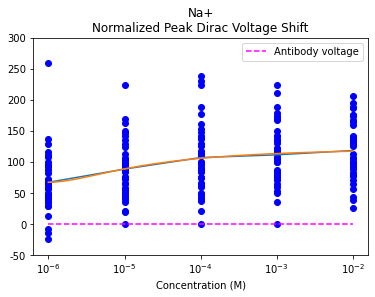

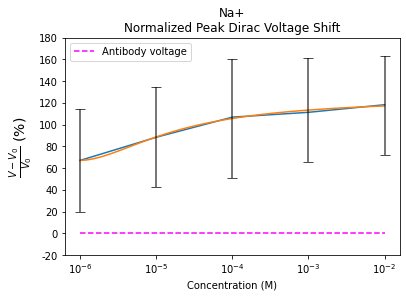

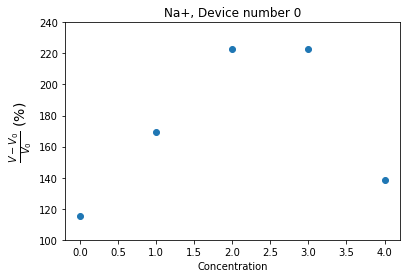

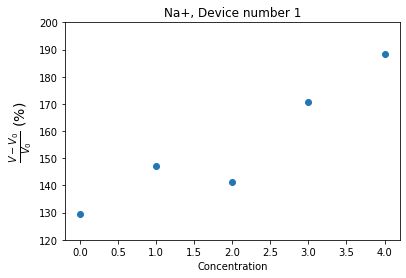

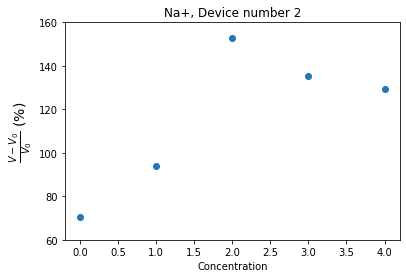

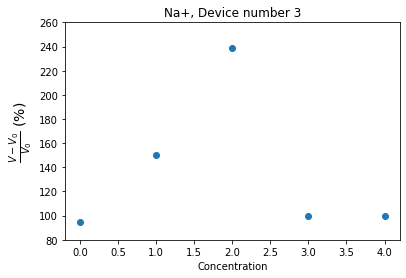

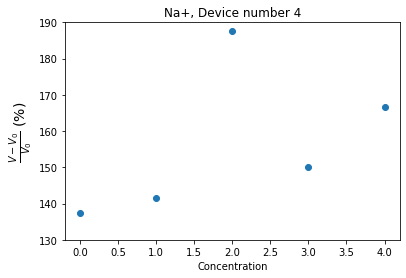

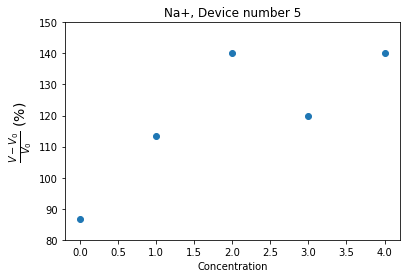

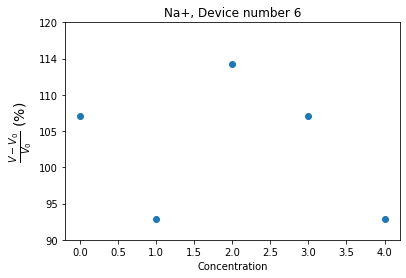

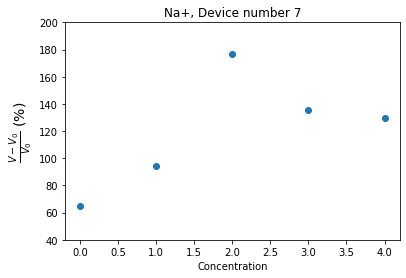

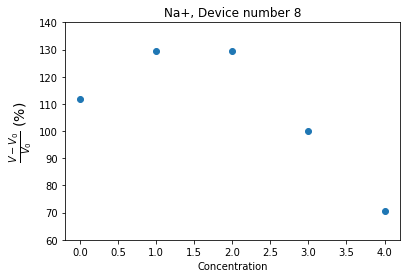

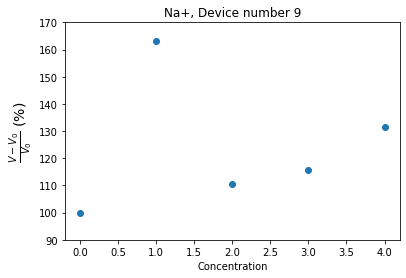

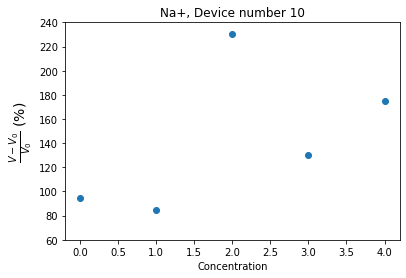

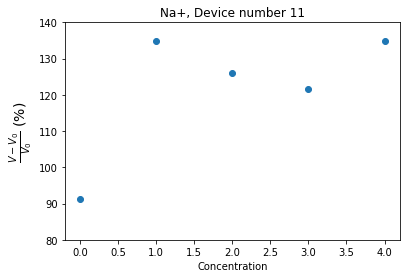

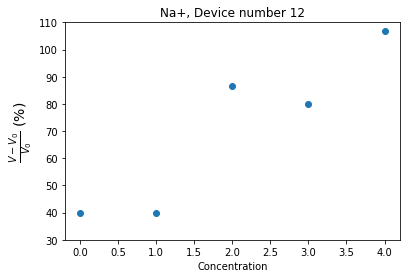

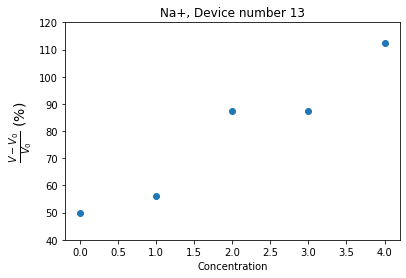

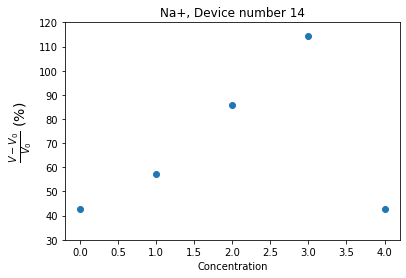

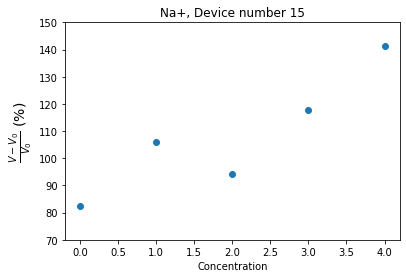

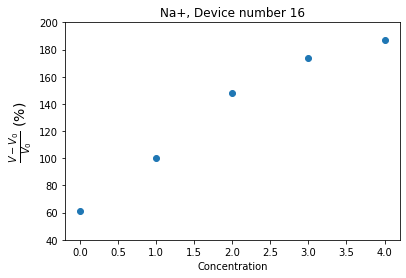

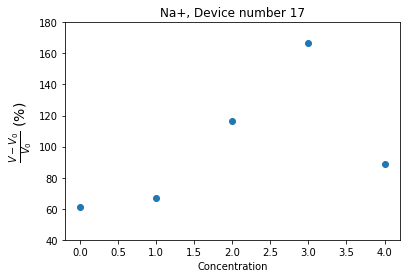

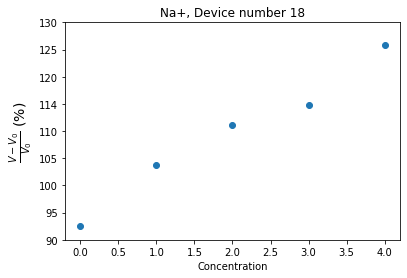

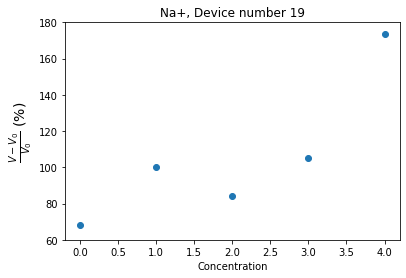

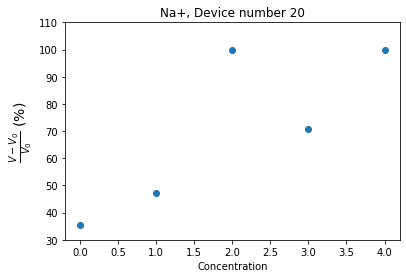

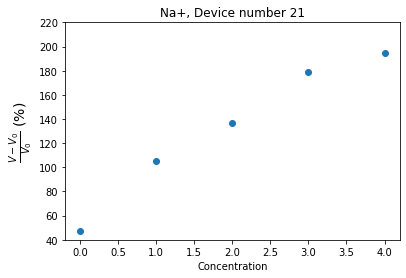

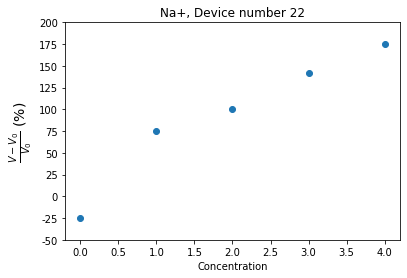

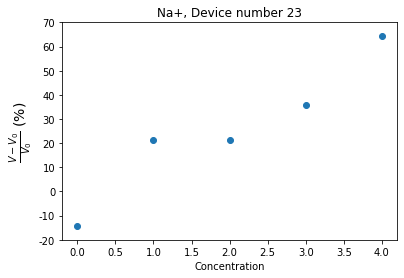

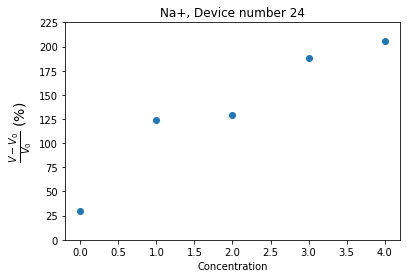

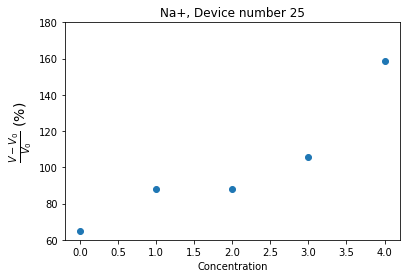

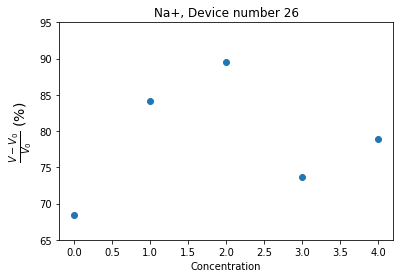

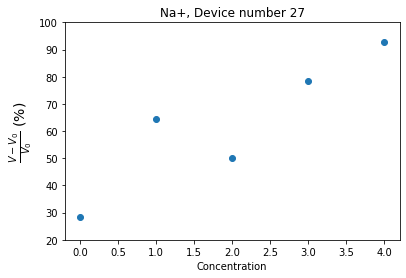

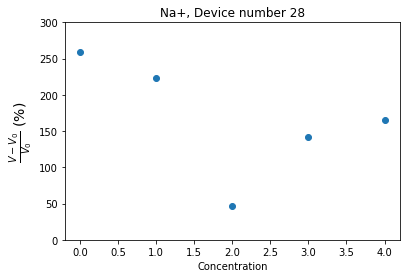

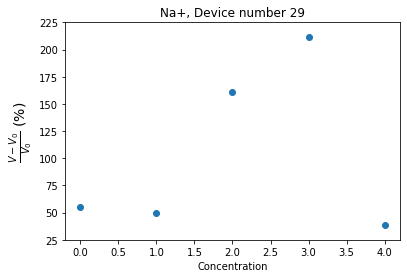

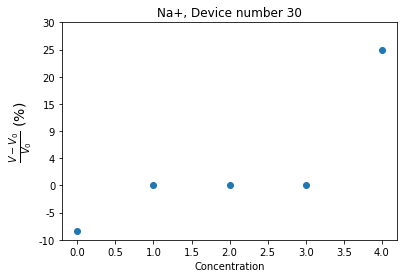

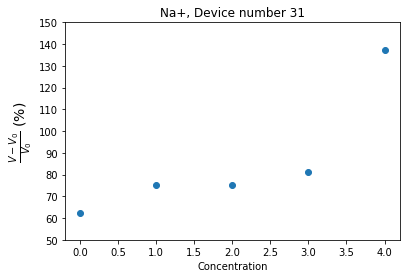

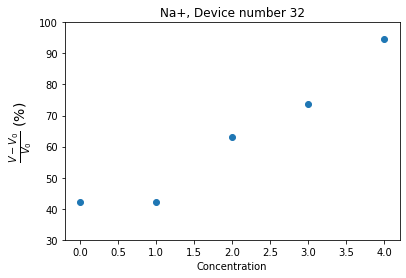

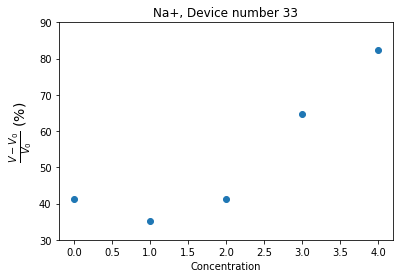

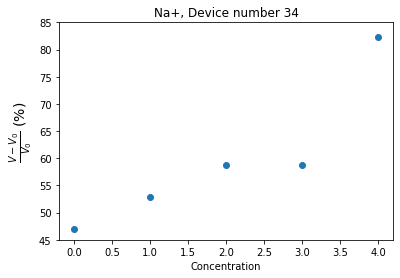

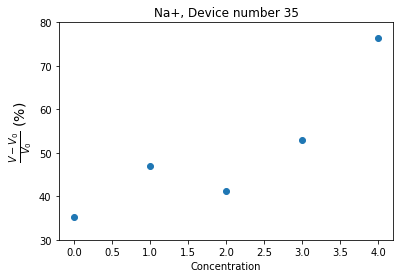

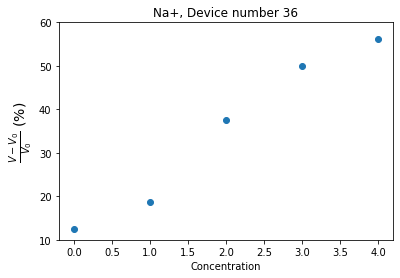

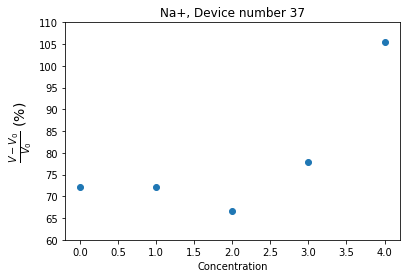

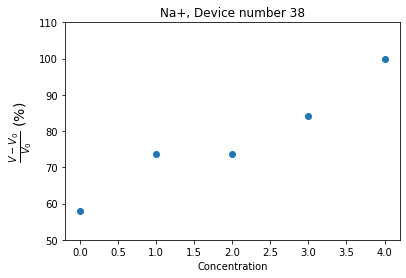

39


TypeError: cannot unpack non-iterable NoneType object

In [333]:
# for RSV, well 3

# filenames to inlude for each concentration
filenames = ['Xue_data_Na/Xue_data_Na_10uM.txt',
             'Xue_data_Na/Xue_data_Na_100uM.txt', 
             'Xue_data_Na/Xue_data_Na_1mM.txt', 
             'Xue_data_Na/Xue_data_Na_10mM.txt', 
             'Xue_data_Na/Xue_data_Na_100mM.txt']

filename_aptamer = 'Xue_data_Na/Xue_data_Na_aptamers.txt'
# filename_id = 'BCdata_rsv/BCdata_B48C13_rsv_initialDirac.txt'
# filename_linker = 'BCdata_rsv/BCdata_B48C13_rsv_linker.txt'

dataset = Dataset(filenames, filename_aptamer) # , filename_id, filename_linker)

concs = range(dataset.num_concs)

# Dirac vaoltage sweep
data_array_2D, hill_coeffs_array, prediction_std_devs, S_mean, S_std, LOD_mean, LOD_std, exp_range_mean, exp_range_std, r2, r2_linear = dataset.sweep_dirac_analysis_normalized()# dataset.sweep_dirac_analysis_normalized()
# print(f'S: {S_mean}, uncertainty: {S_std}')
# print(f'LOD: {str(10**(-18 + LOD_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
# print(f'exp range: {str(10**(-18 + exp_range_mean))}, uncertainty: {str(10**(-18 + exp_range_std))}')
# print(f'r2: {r2}')
# print(f'r2 linear: {r2_linear}')
X_fit = np.linspace(min(concs), max(concs), 50)
Y_fit = hill_function(X_fit, *np.mean(hill_coeffs_array, axis=0))
# plt.plot(X_fit, Y_fit, color = 'black', label=f'n={np.mean(hill_coeffs_array, axis=0)[2]:.4f}', alpha=0.7)
plt.plot(X_fit, Y_fit, color = 'black', alpha=0.7)
plt.errorbar(concs, hill_function(concs, *np.mean(hill_coeffs_array, axis=0)), yerr=prediction_std_devs, ecolor='black', fmt='None', capsize=5, alpha=0.7)
for dev_num in range(data_array_2D.shape[1]):
    plt.scatter(concs, data_array_2D[:, dev_num], marker='o', label=f'Device {dev_num+1}')
# plt.plot([0,9], [0,0], color='magenta', linestyle='--', label='Aptamer voltage')
x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
plt.xticks(range(dataset.num_concs), x_labels)
plt.legend()
# plt.title('RSV\nNormalized Peak Dirac Voltage Shift')
# plt.xlabel("Concentration (g/ml)")
# plt.ylabel(rf'$\frac{{V-V_0}}{{V_0}}$ (%)', fontsize=14)
# x_labels = [f"$10^{{{i}}}$" for i in np.array(range(dataset.num_concs))-18]
# plt.xticks(range(dataset.num_concs), x_labels)
plt.show()
plt.close()

[1.         2.         3.         4.         5.         6.
 7.         8.         9.         6.33333333]


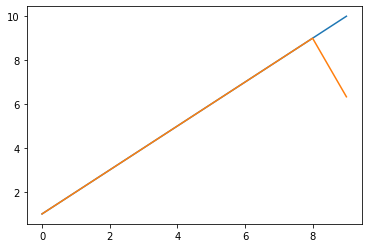

In [314]:
# Example array
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Define the window size
window_size = 3

# Apply mean filter with centered window
filtered_data = np.convolve(data, np.ones(window_size)/window_size, mode='same')
print(filtered_data)

plt.plot(data)
plt.plot(filtered_data)
plt.show()
plt.close()

In [315]:
data = np.array([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])

# Define padding size
pad_size = 5

# Pad the array with zeros on both sides
padded_data = np.pad(data, pad_size, mode='constant', constant_values=0)
print(padded_data)

[ 0  0  0  0  0  1  2  3  4  5  6  7  8  9 10  0  0  0  0  0]
